In [13]:
import os

import numpy as np
import pandas as pd
import cv2
import math
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T

In [14]:
train_data= pd.read_csv("../ELEC576project/sartorius-cell-instance-segmentation/train.csv")

In [15]:
def rotate_image(image, angle):
    
    # Get the image size
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

In [16]:
def largest_rotated_rect(w, h, angle):
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )

In [17]:
def crop_around_center(image, width, height):

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]

In [18]:
def plot_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

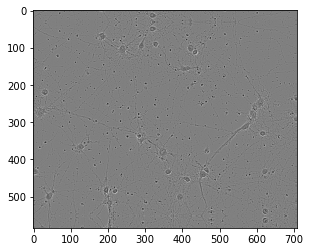

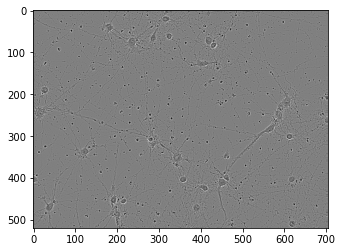

In [35]:
id = "0ba181d412da"
sample_image_df = train_data[train_data['id'] == id]
sample_path = f"../ELEC576project/sartorius-cell-instance-segmentation/train/{sample_image_df['id'].iloc[0]}/{sample_image_df['id'].iloc[0]}.png"
image = cv2.imread(sample_path,cv2.IMREAD_COLOR)
image_height= image.shape[0]
image_width = image.shape[1]


# for i in np.arange(0, 360, 1):
#     image_orig = np.copy(image)
#     image_rotated = rotate_image(image, i)
#     image_rotated_cropped = crop_around_center(
#         image_rotated,
#         *largest_rotated_rect(
#             256,
#             256,
#             math.radians(i)
#         )
#     )

# img2 = np.zeros(image.shape, np.uint8)
# dst = np.zeros((image_height*2, image_width,3),np.uint8)

# for i in range (image_height):
#     for j in range (image_width):
#         img2[i,j]=image[image_height-1-i,j]
    
# for i in range (image_height):
#     for j in range (image_width):
#         dst[i,j]=image[i,j]
#         dst[i+image_height,j]=img2[i,j]

# plt.figure(figsize=(16, 32))
# plt.subplot(3, 1, 1)
# plt.imshow(image_orig) 
# plt.axis("off")
# plt.subplot(3, 1, 2)
# plt.imshow(image_rotated) 
# plt.axis("off")
# plt.subplot(3, 1, 3)
# plt.imshow(image_rotated_cropped) 
# plt.axis("off")



# srcScalar = np.float32([[0.5,0,0],[0,0.5,0]])
# image = cv2.warpAffine(image, srcScalar, (int(image_width*0.5), int(image_height*0.5)))
# image = cv2.imread(sample_path,1)
# image_height= image.shape[0]
# image_width = image.shape[1]
# cv2.line(dst,(0,image_height),(image_width,image_height),(0,0,255))
# cv2.imshow('img', dst)
# cv2.waitKey(0)


# torchvision image reflect
torch.manual_seed(0)
image2 = T.ToPILImage()(image)
image2 = T.Pad(padding=(2,32), padding_mode='reflect')(image2)
image2 = T.ToTensor()(image2)
plot_image(image2)

#revert to original size
image3 = T.ToPILImage()(image2)
image3 = T.RandomCrop(size=(520,704))(image3)
image3 = T.ToTensor()(image3)
plot_image(image3)


In [12]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

example = np.array([1,1,1,1,0,0,0,1,0,1,1,0,0,0,1,1,1])
rle_encoded = encode_mask_to_rle(example)
print(rle_encoded)

1 4 8 1 10 2 15 3
